In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [3]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

#import lightgbm as lgb

In [4]:
pd.options.display.max_columns = 100

In [5]:
df = pd.read_parquet('../data/curated/merchant_consumer_abs')
df

,postcode,total_earners,median_age,income_sum,income_median,income_mean,2021_population,km2,persons/km2,merchant_name,revenue_level,user_id,order_datetime,products,take_rate,category,dollar_value,order_year,order_month,order_day,consumer,consumer_address,consumer_state,consumer_postcode,consumer_gender,fraud_group
0,0800,5631.999974,33.0,4.206090e+08,57789.000082,74682.000125,7678.999968,3.2,2419.999994,Elit Sed Consequat Associates,a,10413,2022-04-27,artist supply and craft shops,5.89,art and gifts,375.167732,2022,4,27,Kelly Clayton,4211 Rodney Tunnel Suite 525,NT,0800,Female,0
1,0800,5631.999974,33.0,4.206090e+08,57789.000082,74682.000125,7678.999968,3.2,2419.999994,Elit Sed Consequat Associates,a,22246,2022-10-07,artist supply and craft shops,5.89,art and gifts,617.879131,2022,10,7,Corey Estrada,1703 Boyd Shore,NT,0800,Male,0
2,0800,5631.999974,33.0,4.206090e+08,57789.000082,74682.000125,7678.999968,3.2,2419.999994,Elit Sed Consequat Associates,a,2681,2022-02-28,artist supply and craft shops,5.89,art and gifts,766.507707,2022,2,28,Nicole Bishop,467 Robert Islands Apt. 834,NT,0800,Female,0
3,0800,5631.999974,33.0,4.206090e+08,57789.000082,74682.000125,7678.999968,3.2,2419.999994,Malesuada Vel Ltd,b,13454,2021-07-24,books periodicals and newspapers,3.56,books and music,258.865959,2021,7,24,Natalie Herrera,88798 Saunders Hills Apt. 945,NT,0800,Female,0
4,0800,5631.999974,33.0,4.206090e+08,57789.000082,74682.000125,7678.999968,3.2,2419.999994,Varius Orci Institute,a,10146,2021-08-08,tent and awning shops,6.30,outdoors,4.159038,2021,8,8,Shannon Mann,00817 Owens Circle,NT,0800,Female,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11087920,7470,1985.000000,45.0,1.157059e+08,49789.000000,58290.000000,4373.000000,3931.6,1.100000,Ipsum Primis Associates,a,7056,2021-07-17,watch clock and jewelry repair shops,6.94,fashion and accessories,56.702387,2021,7,17,Shannon Petty,386 Aaron Manors,TAS,7470,Female,0
11087921,7470,1985.000000,45.0,1.157059e+08,49789.000000,58290.000000,4373.000000,3931.6,1.100000,Ipsum Primis Associates,a,18868,2022-03-11,watch clock and jewelry repair shops,6.94,fashion and accessories,84.885059,2022,3,11,Michael Bush,47924 Jessica Drive Apt. 344,TAS,7470,Male,0
11087922,7470,1985.000000,45.0,1.157059e+08,49789.000000,58290.000000,4373.000000,3931.6,1.100000,Lorem Foundation,a,2243,2021-05-12,digital goods books movies music,6.55,books and music,41.906740,2021,5,12,Kevin Brown,1861 Tina Junction Suite 680,TAS,7470,Undisclosed,0
11087923,7470,1985.000000,45.0,1.157059e+08,49789.000000,58290.000000,4373.000000,3931.6,1.100000,Lorem Foundation,a,2243,2022-01-06,digital goods books movies music,6.55,books and music,9.540977,2022,1,6,Kevin Brown,1861 Tina Junction Suite 680,TAS,7470,Undisclosed,0


In [6]:
import time
import datetime
string_lwr = "2022-08-31"

date_time_lwr = datetime.datetime.strptime(string_lwr, '%Y-%m-%d')
df_train = df.loc[df['order_datetime'] <= date_time_lwr.date()]
df_train.shape[0]

9873203

In [7]:
df_test = df.loc[df['order_datetime'] > date_time_lwr.date()]
df_test.shape[0]

1214722

### get total transactions and revenue by each merchant, with their take rate

In [8]:
df_agg = df_train.groupby(by=['merchant_name']).agg(
    # total_transaction=('postcode', 'count'),
    total_revenue=('dollar_value', np.sum),
    take_rate=('take_rate', np.max)
    ).reset_index()

df_agg_test = df_test.groupby(by=['merchant_name']).agg(
    # total_transaction=('postcode', 'count'),
    total_revenue=('dollar_value', np.sum),
    take_rate=('take_rate', np.max)
    ).reset_index()

In [9]:
df_agg_test

,merchant_name,total_revenue,take_rate
0,A Aliquet Ltd,18526.702082,3.87
1,A Arcu Industries,82962.908601,3.00
2,A Arcu Sed Company,15901.501040,2.38
3,A Associates,3123.346442,4.95
4,A Auctor Non Corporation,77405.961911,5.58
...,...,...,...
3668,Vulputate Ullamcorper Magna LLC,7394.804397,2.51
3669,Vulputate Ullamcorper Magna Ltd,2214.490152,6.18
3670,Vulputate Velit Eu Incorporated,1264.726960,4.76
3671,Vulputate Velit Eu Limited,25297.623159,3.09


### select columns that will be used in the model

In [10]:
df2 = df_train.groupby(by=['merchant_name']).agg(
    total_earners=('total_earners', np.mean),
    median_age=('median_age', np.mean),
    income_median=('income_median', np.mean),
    population_density=('persons/km2', np.mean),
    category=('category', np.max),
    revenue_level=('revenue_level', np.max)
    ).reset_index()

df2_test = df_test.groupby(by=['merchant_name']).agg(
    total_earners=('total_earners', np.mean),
    median_age=('median_age', np.mean),
    income_median=('income_median', np.mean),
    population_density=('persons/km2', np.mean),
    category=('category', np.max),
    revenue_level=('revenue_level', np.max)
    ).reset_index()
df2

,merchant_name,total_earners,median_age,income_median,population_density,category,revenue_level
0,A Aliquet Ltd,4798.929084,43.814320,46262.536570,567.765402,home and technology,b
1,A Arcu Industries,4858.048364,43.031207,45990.336590,584.778167,outdoors,c
2,A Arcu Sed Company,4981.222340,43.565061,47007.237768,619.194289,fashion and accessories,c
3,A Arcu Sed Corporation,4731.045332,40.962152,47077.062398,508.682908,books and music,c
4,A Associates,4681.818192,45.054631,42485.704990,317.757139,fashion and accessories,b
...,...,...,...,...,...,...,...
3884,Vulputate Ullamcorper Magna LLC,5460.732711,42.110821,45919.672097,532.201391,outdoors,c
3885,Vulputate Ullamcorper Magna Ltd,4533.208908,42.886811,46272.150204,524.894962,home and technology,a
3886,Vulputate Velit Eu Incorporated,4686.139937,42.101435,45134.470264,449.884749,fashion and accessories,b
3887,Vulputate Velit Eu Limited,4916.584353,43.277228,46084.563723,567.166521,outdoors,c


In [11]:
df3 = df_train.groupby('merchant_name')['consumer_state'].nunique()
df3.to_frame()
df3.reset_index()

df3_test = df_test.groupby('merchant_name')['consumer_state'].nunique()
df3_test.to_frame()
df3_test.reset_index()

,merchant_name,consumer_state
0,A Aliquet Ltd,8
1,A Arcu Industries,8
2,A Arcu Sed Company,7
3,A Associates,5
4,A Auctor Non Corporation,8
...,...,...
3668,Vulputate Ullamcorper Magna LLC,6
3669,Vulputate Ullamcorper Magna Ltd,4
3670,Vulputate Velit Eu Incorporated,3
3671,Vulputate Velit Eu Limited,8


In [12]:
df2 = df2.merge(df3, how='inner', on=['merchant_name'])
df2_test = df2_test.merge(df3_test, how='inner', on=['merchant_name'])
df2

,merchant_name,total_earners,median_age,income_median,population_density,category,revenue_level,consumer_state
0,A Aliquet Ltd,4798.929084,43.814320,46262.536570,567.765402,home and technology,b,8
1,A Arcu Industries,4858.048364,43.031207,45990.336590,584.778167,outdoors,c,8
2,A Arcu Sed Company,4981.222340,43.565061,47007.237768,619.194289,fashion and accessories,c,8
3,A Arcu Sed Corporation,4731.045332,40.962152,47077.062398,508.682908,books and music,c,7
4,A Associates,4681.818192,45.054631,42485.704990,317.757139,fashion and accessories,b,7
...,...,...,...,...,...,...,...,...
3884,Vulputate Ullamcorper Magna LLC,5460.732711,42.110821,45919.672097,532.201391,outdoors,c,6
3885,Vulputate Ullamcorper Magna Ltd,4533.208908,42.886811,46272.150204,524.894962,home and technology,a,7
3886,Vulputate Velit Eu Incorporated,4686.139937,42.101435,45134.470264,449.884749,fashion and accessories,b,6
3887,Vulputate Velit Eu Limited,4916.584353,43.277228,46084.563723,567.166521,outdoors,c,8


### calculate transaction_per_day and revenue (taken) per day

In [13]:
TIME_SPAN_1 = len(list(set(df_train['order_datetime'])))

TIME_SPAN_2 = len(list(set(df_test['order_datetime'])))
TIME_SPAN_2

56

In [14]:
# df_agg['transaction_per_day'] = df_agg['total_transaction'] / TIME_SPAN
df_agg['revenue_per_day'] = df_agg['total_revenue'] / TIME_SPAN_1
df_agg['revenue_taken'] = df_agg['revenue_per_day'] * (df_agg['take_rate'] / 100)

df_agg_test['revenue_per_day'] = df_agg_test['total_revenue'] / TIME_SPAN_2
df_agg_test['revenue_taken'] = df_agg_test['revenue_per_day'] * (df_agg_test['take_rate'] / 100)
df_agg

,merchant_name,total_revenue,take_rate,revenue_per_day,revenue_taken
0,A Aliquet Ltd,177262.924235,3.87,322.296226,12.472864
1,A Arcu Industries,751943.620901,3.00,1367.170220,41.015107
2,A Arcu Sed Company,134365.813815,2.38,244.301480,5.814375
3,A Arcu Sed Corporation,10786.692787,3.06,19.612169,0.600132
4,A Associates,21515.268600,4.95,39.118670,1.936374
...,...,...,...,...,...
3884,Vulputate Ullamcorper Magna LLC,26060.305591,2.51,47.382374,1.189298
3885,Vulputate Ullamcorper Magna Ltd,24110.588839,6.18,43.837434,2.709153
3886,Vulputate Velit Eu Incorporated,19732.887885,4.76,35.877978,1.707792
3887,Vulputate Velit Eu Limited,204611.811213,3.09,372.021475,11.495464


In [15]:
df_agg = df_agg.drop(columns=['total_revenue', 'take_rate', 'revenue_per_day'])

df_agg_test = df_agg_test.drop(columns=['total_revenue', 'take_rate', 'revenue_per_day'])

In [16]:
df_final = df_agg.merge(df2, on='merchant_name', how='inner')
df_final_test = df_agg_test.merge(df2_test, on='merchant_name', how='inner')
df_final

,merchant_name,revenue_taken,total_earners,median_age,income_median,population_density,category,revenue_level,consumer_state
0,A Aliquet Ltd,12.472864,4798.929084,43.814320,46262.536570,567.765402,home and technology,b,8
1,A Arcu Industries,41.015107,4858.048364,43.031207,45990.336590,584.778167,outdoors,c,8
2,A Arcu Sed Company,5.814375,4981.222340,43.565061,47007.237768,619.194289,fashion and accessories,c,8
3,A Arcu Sed Corporation,0.600132,4731.045332,40.962152,47077.062398,508.682908,books and music,c,7
4,A Associates,1.936374,4681.818192,45.054631,42485.704990,317.757139,fashion and accessories,b,7
...,...,...,...,...,...,...,...,...,...
3884,Vulputate Ullamcorper Magna LLC,1.189298,5460.732711,42.110821,45919.672097,532.201391,outdoors,c,6
3885,Vulputate Ullamcorper Magna Ltd,2.709153,4533.208908,42.886811,46272.150204,524.894962,home and technology,a,7
3886,Vulputate Velit Eu Incorporated,1.707792,4686.139937,42.101435,45134.470264,449.884749,fashion and accessories,b,6
3887,Vulputate Velit Eu Limited,11.495464,4916.584353,43.277228,46084.563723,567.166521,outdoors,c,8


In [17]:
df_final = df_final.drop(columns=['merchant_name'])
df_final['category'] = df_final['category'].astype('object')
df_final['revenue_level'] = df_final['revenue_level'].astype('object')
df_final_test = df_final_test.drop(columns=['merchant_name'])
df_final_test['category'] = df_final_test['category'].astype('object')
df_final_test['revenue_level'] = df_final_test['revenue_level'].astype('object')
df_final

,revenue_taken,total_earners,median_age,income_median,population_density,category,revenue_level,consumer_state
0,12.472864,4798.929084,43.814320,46262.536570,567.765402,home and technology,b,8
1,41.015107,4858.048364,43.031207,45990.336590,584.778167,outdoors,c,8
2,5.814375,4981.222340,43.565061,47007.237768,619.194289,fashion and accessories,c,8
3,0.600132,4731.045332,40.962152,47077.062398,508.682908,books and music,c,7
4,1.936374,4681.818192,45.054631,42485.704990,317.757139,fashion and accessories,b,7
...,...,...,...,...,...,...,...,...
3884,1.189298,5460.732711,42.110821,45919.672097,532.201391,outdoors,c,6
3885,2.709153,4533.208908,42.886811,46272.150204,524.894962,home and technology,a,7
3886,1.707792,4686.139937,42.101435,45134.470264,449.884749,fashion and accessories,b,6
3887,11.495464,4916.584353,43.277228,46084.563723,567.166521,outdoors,c,8


In [18]:
df_final_test

,revenue_taken,total_earners,median_age,income_median,population_density,category,revenue_level,consumer_state
0,12.803274,5394.449707,43.040069,48321.893794,742.236533,home and technology,b,8
1,44.444415,4698.692054,43.009855,46091.448538,556.381979,outdoors,c,8
2,6.758138,5195.204002,43.422231,46572.203912,637.268230,fashion and accessories,c,7
3,2.760815,7271.932781,44.457873,50125.617821,865.137906,fashion and accessories,b,5
4,77.129512,4857.058626,43.226365,46006.216772,580.259995,fashion and accessories,a,8
...,...,...,...,...,...,...,...,...
3668,3.314457,4803.094976,40.739407,44441.534663,639.365044,outdoors,c,6
3669,2.443848,5588.217682,41.402506,43841.084349,535.814323,home and technology,a,4
3670,1.075018,4133.414781,45.833062,48791.062379,558.087988,fashion and accessories,b,3
3671,13.958867,4804.009864,43.110915,46361.413879,600.798857,outdoors,c,8


In [19]:
df_final = pd.get_dummies(df_final)
df_final_test = pd.get_dummies(df_final_test)

In [20]:
# df_final.to_csv('../data/curated/transaction & revenue.csv', encoding='utf-8', index=False)

In [21]:
# transaction数量和revenue的权重暂定1:2
# df_final['score'] = df_final['transaction_per_day']


In [22]:
df_final_test

,revenue_taken,total_earners,median_age,income_median,population_density,consumer_state,category_art and gifts,category_books and music,category_fashion and accessories,category_home and technology,category_outdoors,revenue_level_a,revenue_level_b,revenue_level_c,revenue_level_d,revenue_level_e
0,12.803274,5394.449707,43.040069,48321.893794,742.236533,8,0,0,0,1,0,0,1,0,0,0
1,44.444415,4698.692054,43.009855,46091.448538,556.381979,8,0,0,0,0,1,0,0,1,0,0
2,6.758138,5195.204002,43.422231,46572.203912,637.268230,7,0,0,1,0,0,0,0,1,0,0
3,2.760815,7271.932781,44.457873,50125.617821,865.137906,5,0,0,1,0,0,0,1,0,0,0
4,77.129512,4857.058626,43.226365,46006.216772,580.259995,8,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,3.314457,4803.094976,40.739407,44441.534663,639.365044,6,0,0,0,0,1,0,0,1,0,0
3669,2.443848,5588.217682,41.402506,43841.084349,535.814323,4,0,0,0,1,0,1,0,0,0,0
3670,1.075018,4133.414781,45.833062,48791.062379,558.087988,3,0,0,1,0,0,0,1,0,0,0
3671,13.958867,4804.009864,43.110915,46361.413879,600.798857,8,0,0,0,0,1,0,0,1,0,0


#### check normal distribution

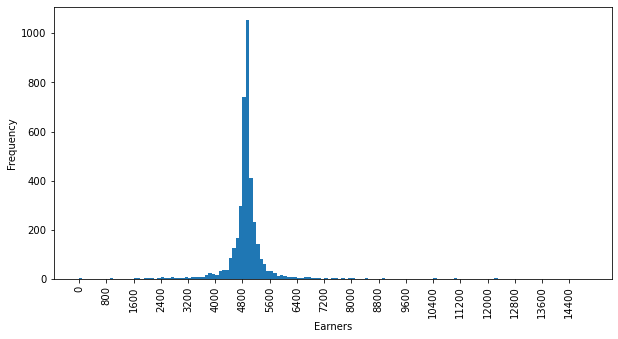

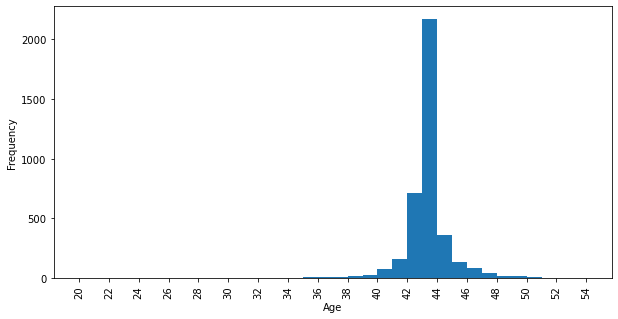

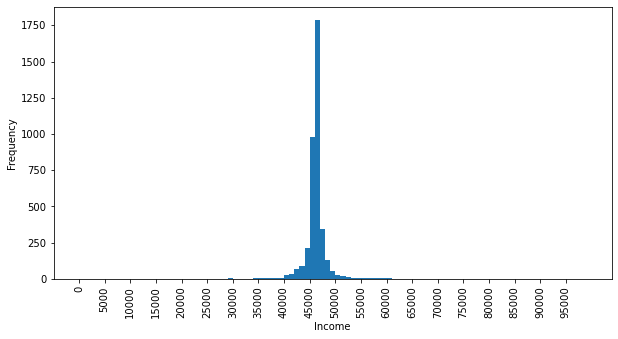

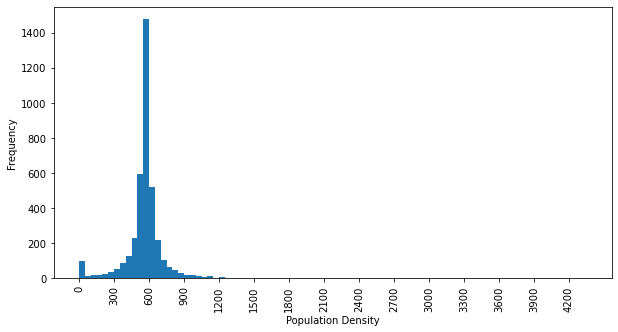

In [23]:
df_final["total_earners"].plot.hist(bins=np.arange(0,15000,100),figsize=(10, 5),legend=False)
plt.xticks(np.arange(0,15000,800))
plt.xticks(rotation=90)
plt.xlabel("Earners")
plt.show()

df_final["median_age"].plot.hist(bins=np.arange(20,55,1),figsize=(10, 5),legend=False)
plt.xticks(np.arange(20,55,2))
plt.xticks(rotation=90)
plt.xlabel("Age")
plt.show()

df_final["income_median"].plot.hist(bins=np.arange(0,100000,1000),figsize=(10, 5),legend=False)
plt.xticks(np.arange(0,100000,5000))
plt.xticks(rotation=90)
plt.xlabel("Income")
plt.show()

df_final["population_density"].plot.hist(bins=np.arange(0,4400,50),figsize=(10, 5),legend=False)
plt.xticks(np.arange(0,4400,300))
plt.xticks(rotation=90)
plt.xlabel("Population Density")
plt.show()

#### check linear relationship

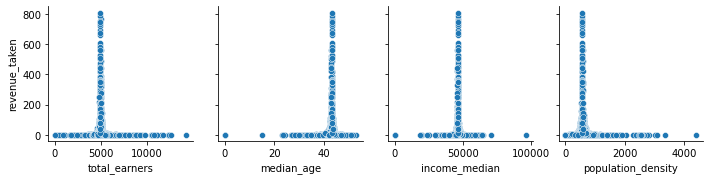

In [24]:
sns.pairplot(df_final, x_vars=['total_earners', 'median_age', 'income_median', 'population_density'], y_vars='revenue_taken')

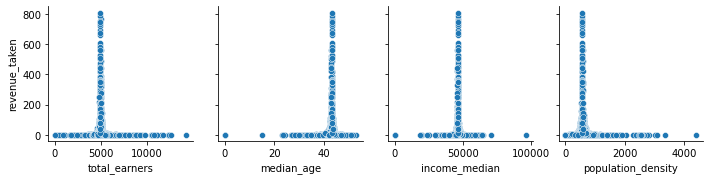

In [25]:
#df_final['revenue_taken'] = np.log(df_final['revenue_taken'])
sns.pairplot(df_final, x_vars=['total_earners', 'median_age', 'income_median', 'population_density'], y_vars='revenue_taken')

In [26]:
#df_final_test['revenue_taken'] = np.log(df_final_test['revenue_taken'])

In [27]:
lasso = Lasso(alpha=0.0005)
lasso_model = lasso.fit(df_final.loc[:, df_final.columns!='revenue_taken'], df_final['revenue_taken'])
y_pred_ls = lasso_model.predict(df_final_test.loc[:, df_final_test.columns!='revenue_taken'])
#print(type(df_final_test['revenue_taken']))
#y_test = df_final_test['revenue_taken'].values.tolist()
r2_score_ls = lasso_model.score(df_final_test.loc[:, df_final_test.columns!='revenue_taken'], df_final_test['revenue_taken'])
print('r2_score: {:4.3f}'.format(r2_score_ls))
# rmse= np.mean(np.sqrt(-cross_val_score(lasso, df_final.loc[:, df_final.columns!='revenue_taken'], df_final['revenue_taken'], scoring="neg_mean_squared_error", cv = 5)))
# print(rmse)

r2_score: 0.073


/Users/xieyufeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1437370.0322175827, tolerance: 1767.8568295057692
  model = cd_fast.enet_coordinate_descent(


In [28]:
GBoost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01,
                                   max_depth=4, max_features='auto',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
GB_model = GBoost.fit(df_final.loc[:, df_final.columns!='revenue_taken'], df_final['revenue_taken'])
y_pred = GB_model.predict(df_final_test.loc[:, df_final_test.columns!='revenue_taken'])
r2_score_gb = metrics.r2_score(df_final_test['revenue_taken'], y_pred)
print('r2_score: {:4.3f}'.format(r2_score_gb))
#rmse= np.mean(np.sqrt(-cross_val_score(GBoost, df_final.loc[:, df_final.columns!='revenue_taken'], df_final['revenue_taken'], scoring="neg_mean_squared_error", cv = 5)))
#print(rmse)

r2_score: 0.061


In [29]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[300, 500, 1000],'learning_rate':[0.01],
                'max_depth':[3, 4, 5], 'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
                'min_samples_split':[5, 10, 20], 'min_samples_leaf':[5, 10, 20]}
Gboost = GradientBoostingRegressor()
clf = GridSearchCV(Gboost,parameters)
clf.fit(df_final.loc[:, df_final.columns!='revenue_taken'], df_final['revenue_taken'])
clf.best_params_

/Users/xieyufeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/xieyufeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/xieyufeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 448, in fit
    self._check_params()
  File "/Users/xieyufeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'squared_error' not supported. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/xieyufeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615

KeyboardInterrupt: 